# Aufgabe 15: _𝑘-NN Klassifikation_

### a)

Unterscheiden sich die Attribute stark in ihrer Größenordnung, dann werden diese unterschiedlich stark gewichtet wodurch der Klassifizierer nicht mehr so genau arbeiten kann.

### b)

Der k-NN wird als "lazy learner" bezeichnet, weil der Algorithmus die Trainingsdaten nicht verwendet, um zu generalisieren, sondern den Trainingsdatensatz auswendig lernt.

### c)

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

class KNN:
    '''KNN Classifier.

    Attributes
    ----------
    k : int
        Number of neighbors to consider.
    '''
    def __init__(self, k):
        '''Initialization.
        Parameters are stored as member variables/attributes.
        
        Parameters
        ----------
        k : int
            Number of neighbors to consider.
        '''
        self.k = k

    def fit(self, X, y):
        '''Fit routine.
        Training data is stored within object.
        
        Parameters
        ----------
        X : numpy.array, shape=(n_samples, n_attributes)
            Training data.
        y : numpy.array shape=(n_samples)
            Training labels.
        '''
        self.train_data = X
        self.train_labels = y

    def predict(self, X):
        '''Prediction routine.
        Predict class association of each sample of X.
        
        Parameters
        ----------
        X : numpy.array, shape=(n_samples, n_attributes)
            Data to classify.
        
        Returns
        -------
        prediction : numpy.array, shape=(n_samples)
            Predictions, containing the predicted label of each sample.
        '''
        
        self.test_data = X
        
        predicted_labels = []
        
        for i in range(len(self.test_data)):
            background = 0
            signal = 0
            
            xx = self.test_data[i]
            
            distance = cdist(xx, self.train_data)[0]
            distance_list = np.stack((distance, self.train_labels), axis=1)
            
            sorted_distance_list = distance_list[np.argsort(distance_list[:,0])]
            neighbours = sorted_distance_list[:self.k]
            
            for j in range(self.k):
                if neighbours[j,1] == 0:
                    background += 1
                else:
                    signal +=1
            if background >= signal:
                predicted_labels.append(0)
            elif background < signal:
                predicted_labels.append(1)
                
        return np.array(predicted_labels)

### d)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [27]:
def getdata(file, key, log = False):
    data = pd.read_hdf(file, key)
    
    hits = np.array(data.NumberOfHits[~np.isnan(data.NumberOfHits)])
    if log == True:
        hits = np.log10(hits)
    
    x = np.array(data.x[~np.isnan(data.x)])
    y = np.array(data.y[~np.isnan(data.y)])
    
    return np.matrix([hits, x, y]).T


def splitdata(signal, background, n_train, n_sig, n_back, shuffle = False, seed = 0):
    if shuffle == True:
        signal, background = shuffle(signal, background, random_state=seed)
    
    signal = signal[:n_train+n_sig:]
    background = background[:n_train+n_back:]
    
    train_sig, test_sig = np.split(signal, [n_train])
    train_back, test_back = np.split(background, [n_train])

    train_data = np.concatenate((train_back, train_sig))

    labels = np.concatenate((np.zeros(n_train),np.ones(n_train))) # 0=Background, 1=Signal
    
    return train_data, test_back, test_sig, labels

In [14]:
signal = getdata('NeutrinoMC.hdf5', 'Signal')
background = getdata('NeutrinoMC.hdf5', 'Background')

n_train = 5000
n_sig = 10000
n_back = 20000
k = 10

In [28]:
train_data, test_back, test_sig, labels = splitdata(signal, background, n_train, n_sig, n_back)

Text(0,0.5,'$y$')

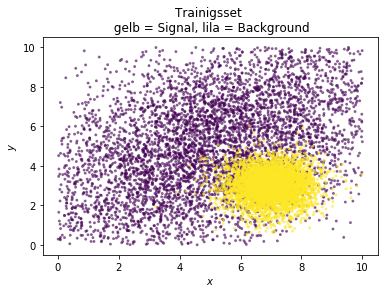

In [18]:
x = np.ravel(train_data[:,1])
y = np.ravel(train_data[:,2])

plt.scatter(x, y, marker='.', c = labels, alpha = 0.5,
            s=15)#, edgecolor='k', linewidths=0.3)

plt.title('Trainigsset \n gelb = Signal, lila = Background')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Text(0,0.5,'$y$')

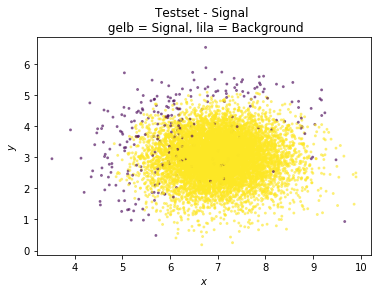

In [23]:
knn = KNN(k)

x_sig = np.ravel(test_sig[:,1])
y_sig = np.ravel(test_sig[:,2])

knn.fit(train_data, labels)
predict_labels_sig = knn.predict(test_sig)

plt.scatter(x_sig, y_sig, marker='.', c = predict_labels_sig, alpha = 0.5,
            s=15)#, edgecolor='k', linewidths=0.3)

plt.title('Testset - Signal \n gelb = Signal, lila = Background')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Text(0,0.5,'$y$')

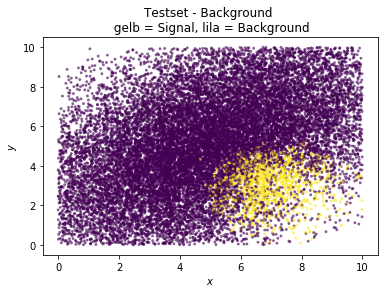

In [24]:
x_back = np.ravel(test_back[:,1])
y_back = np.ravel(test_back[:,2])

knn.fit(train_data, labels)
predict_labels_back = knn.predict(test_back)

plt.scatter(x_back, y_back, marker='.', c = predict_labels_back, alpha = 0.5,
            s=15)#, edgecolor='k', linewidths=0.3)

plt.title('Testset - Background \n gelb = Signal, lila = Background')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Text(0,0.5,'$y$')

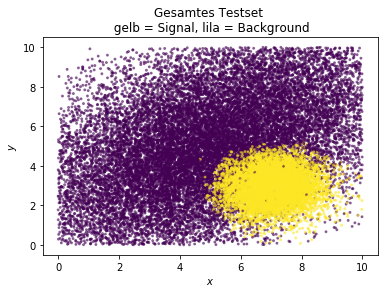

In [26]:
plt.scatter(x_back, y_back, marker='.', c = predict_labels_back, alpha = 0.5,
            s=15)#, edgecolor='k', linewidths=0.3)

plt.scatter(x_sig, y_sig, marker='.', c = predict_labels_sig, alpha = 0.5,
            s=15)#, edgecolor='k', linewidths=0.3)

plt.title('Gesamtes Testset \n gelb = Signal, lila = Background')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [9]:
def validation(k, train_data, labels, test_sig, test_back):
    knn = KNN(k)
    knn.fit(train_data, labels)
    
    predict_sig = np.array(knn.predict(test_sig))
    predict_back = np.array(knn.predict(test_back))
    
    tp = np.count_nonzero(predict_sig == 1)
    fn = np.count_nonzero(predict_sig == 0)
    fp = np.count_nonzero(predict_back == 1)
    tn = np.count_nonzero(predict_back == 0)
    
    print('tp =', tp)
    print('fn =', fn)
    print('fp =', fp)
    print('tn =', tn)
    
    Reinheit = tp/(tp+fp)
    Effizienz = tp/(tp+fn)
    Signifikanz = tp/(np.sqrt(tp+fp))
    
    print('Reinheit =', Reinheit)
    print('Effizienz =', Effizienz)
    print('Signifikanz =', Signifikanz)

In [10]:
validation(k, train_data, labels, test_sig, test_back)

tp = 9679
fn = 321
fp = 1824
tn = 18176
Reinheit = 0.8414326697383291
Effizienz = 0.9679
Signifikanz = 90.24537002194234


### e)

In [29]:
log_signal = getdata('NeutrinoMC.hdf5', 'Signal', log=True)
log_background = getdata('NeutrinoMC.hdf5', 'Background', log=True)

train_data, test_back, test_sig, labels = splitdata(log_signal, log_background, n_train, n_sig, n_back)

validation(k, train_data, labels, test_sig, test_back)

tp = 9734
fn = 266
fp = 1299
tn = 18701
Reinheit = 0.8822623039970996
Effizienz = 0.9734
Signifikanz = 92.67114581738896


Werden die $ \log_{10}$(Hits) statt der Hits verwendet, dann verbessern sich Reinheit, Effizienz und Signifikanz des knn-Algorithmus um $1 \%$ bis $4 \%$.

### f)

In [30]:
k = 20

train_data, test_back, test_sig, labels = splitdata(signal, background, n_train, n_sig, n_back)

validation(k, train_data, labels, test_sig, test_back)

tp = 9656
fn = 344
fp = 2054
tn = 17946
Reinheit = 0.8245943637916311
Effizienz = 0.9656
Signifikanz = 89.23162655007467


Bei der Einbeziehung der 20 nächsten Nachbarn für den nicht logarithmierten Datensatz verschlechtern sich die drei Werte, um $1 \%$ bis $2 \%$. Am wenigsten ist dabei die Effizienz betroffen.

In [31]:
train_data, test_back, test_sig, labels = splitdata(log_signal, log_background, n_train, n_sig, n_back)

validation(k, train_data, labels, test_sig, test_back)

tp = 9809
fn = 191
fp = 1465
tn = 18535
Reinheit = 0.8700549937910236
Effizienz = 0.9809
Signifikanz = 92.38165096000478


Beim logarithmierten Datensatz, werden Reinheit und Signifikanz minimal schlechter, während sich die Effizienz verbessert.